In [1]:
from my_code.datasets.surreal_dataset import SingleSurrealDataset

n_body_types_male=8
n_body_types_female=8
n_poses_straight=8
n_poses_bent=0

dataset_32 = SingleSurrealDataset(
    n_body_types_male=n_body_types_male,
    n_body_types_female=n_body_types_female,
    n_poses_straight=n_poses_straight,
    n_poses_bent=n_poses_bent,
    num_evecs=32
)
dataset_64 = SingleSurrealDataset(
    n_body_types_male=n_body_types_male,
    n_body_types_female=n_body_types_female,
    n_poses_straight=n_poses_straight,
    n_poses_bent=n_poses_bent,
    num_evecs=64
)
dataset_128 = SingleSurrealDataset(
    n_body_types_male=n_body_types_male,
    n_body_types_female=n_body_types_female,
    n_poses_straight=n_poses_straight,
    n_poses_bent=n_poses_bent,
    num_evecs=128
)

Generating female shapes: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00,  9.09it/s]


In [3]:
import my_code.diffusion_training.evaluate_samples as evaluate_samples
from tqdm import tqdm

for i in range(10):
    geo_err_32, _, _, _ = evaluate_samples.compare_fmap_with_gt(
        dataset_32[i]['second']['C_gt_xy'],
        dataset_32[i]['first'],
        dataset_32[i]['second'],
    )
    geo_err_64, _, _, _ = evaluate_samples.compare_fmap_with_gt(
        dataset_64[i]['second']['C_gt_xy'],
        dataset_64[i]['first'],
        dataset_64[i]['second'],
    )
    geo_err_128, _, _, _ = evaluate_samples.compare_fmap_with_gt(
        dataset_128[i]['second']['C_gt_xy'],
        dataset_128[i]['first'],
        dataset_128[i]['second'],
    )
    print(f'{i}) 32: {geo_err_32.abs().sum():.2f}, 64: {geo_err_64.abs().sum():.2f}, 128: {geo_err_128.abs().sum():.2f}')
    

0) 32: 170.22, 64: 117.52, 128: 50.17


KeyboardInterrupt: 

In [ ]:
import sys
sys.path.append('/home/s94zalek/shape_matching')

from datasets_code import build_dataloader, build_dataset
from utils.options import parse_options
from train import create_train_val_dataloader
import torch
import numpy as np

import os
os.chdir('/home/s94zalek/shape_matching')

# print current working directory
print(os.getcwd())

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
/home/s94zalek/shape_matching


In [ ]:
import os

# root_path = osp.abspath(osp.join(__file__, osp.pardir))
root_path = '/home/s94zalek/shape_matching'

opt = parse_options(root_path, is_train=False, use_argparse=False,
                    opt_path = 'options/train/faust.yaml')

opt['root_path'] = root_path
opt['dist'] = False

opt['datasets']['train_dataset']['return_corr'] = True
opt['datasets']['train_dataset']['return_dist'] = False
opt['datasets']['test_dataset']['return_dist'] = False

# create train and validation dataloaders
result = create_train_val_dataloader(opt)
train_loader, train_sampler, val_loader, total_epochs, total_iters = result

test_set = build_dataset(opt['datasets']['test_dataset'])
test_loader = build_dataloader(
test_set, opt['datasets']['test_dataset'], phase='val', num_gpu=opt['num_gpu'], dist=opt['dist'], sampler=None, seed=opt['manual_seed'])


Backend DataParallel.
Path already exists. Rename it to /home/s94zalek/shape_matching/results/faust_archived_20240602_164306


Calculating functional maps: 100%|██████████████████████████████████████████████████████████████████████████████████| 400/400 [00:03<00:00, 101.77it/s]


In [ ]:
train_set_faust = train_loader.dataset

In [ ]:
import my_code.diffusion_training.evaluate_samples as evaluate_samples

def reduce_fmap_dimension(data_full, target_dim):
    return {
        'first': {
            'verts': data_full['first']['verts'],
            'corr': data_full['first']['corr'],
            'evecs': data_full['first']['evecs'][:, :target_dim],
            'evals': data_full['first']['evals'][:target_dim],
            'evecs_trans': data_full['first']['evecs_trans'][:target_dim, :],
        },
        'second': {
            'verts': data_full['second']['verts'],
            'corr': data_full['second']['corr'],
            'evecs': data_full['second']['evecs'][:, :target_dim],
            'evals': data_full['second']['evals'][:target_dim],
            'evecs_trans': data_full['second']['evecs_trans'][:target_dim, :],
            'C_gt_xy': data_full['second']['C_gt_xy'][:target_dim, :target_dim]
        }
    }

auc_list = []
pck_list = []
for i in range(4, 100, 10):
    
    data_200_faust = train_set_faust[i]
    data_32_faust = reduce_fmap_dimension(data_200_faust, 32)
    data_64_faust = reduce_fmap_dimension(data_200_faust, 64)
    data_128_faust = reduce_fmap_dimension(data_200_faust, 128)
    
    geo_err_32, _, _, _ = evaluate_samples.compare_fmap_with_gt(
        data_32_faust['second']['C_gt_xy'],
        data_32_faust['first'],
        data_32_faust['second'],
    )
    geo_err_64, _, _, _ = evaluate_samples.compare_fmap_with_gt(
        data_64_faust['second']['C_gt_xy'],
        data_64_faust['first'],
        data_64_faust['second'],
    )
    geo_err_128, _, _, _ = evaluate_samples.compare_fmap_with_gt(
        data_128_faust['second']['C_gt_xy'],
        data_128_faust['first'],
        data_128_faust['second'],
    )
    
    auc, pcks, thresholds = geodist_metric.plot_pck(geo_err_64.numpy(), threshold=0.1, steps=40, show_figure=False)
    auc_list.append(auc)
    pck_list.append(pcks)
    
    print(f'{i}) 32: {geo_err_32.abs().sum():.2f}, 64: {geo_err_64.abs().sum():.2f}, 128: {geo_err_128.abs().sum():.2f}')
    

NameError: name 'train_set_faust' is not defined

In [ ]:
np.mean(auc_list, axis=0), np.mean(pck_list, axis=0)

(0.8483451282051281,
 array([0.26228, 0.30008, 0.30852, 0.33654, 0.37718, 0.43546, 0.50488,
        0.5985 , 0.69152, 0.7666 , 0.8249 , 0.86648, 0.89408, 0.91318,
        0.92784, 0.9391 , 0.94892, 0.95792, 0.9652 , 0.97104, 0.97746,
        0.9828 , 0.98776, 0.99292, 0.99562, 0.9975 , 0.9984 , 0.99896,
        0.99928, 0.99942, 0.99952, 0.9996 , 0.9996 , 0.9996 , 0.9996 ,
        0.9996 , 0.9996 , 0.99962, 0.99968, 0.99968]))

In [ ]:
torch.tensor(auc_list)

NameError: name 'auc_list' is not defined

In [ ]:
import importlib
importlib.reload(geodist_metric)

<module 'metrics.geodist_metric' from '/home/s94zalek/shape_matching/metrics/geodist_metric.py'>

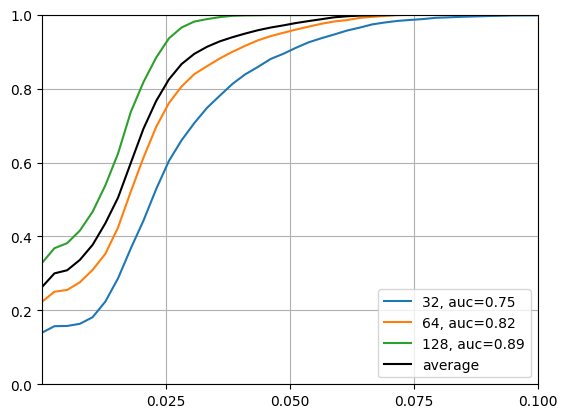

In [ ]:
import metrics.geodist_metric as geodist_metric
import matplotlib.pyplot as plt


fig, ax = plt.subplots(1, 1)

for n_evecs, geo_err in [(32, geo_err_32), (64, geo_err_64), (128, geo_err_128)]:
    auc, pcks, thresholds = geodist_metric.plot_pck(geo_err.numpy(), threshold=0.1, steps=40, show_figure=False)
    ax.plot(thresholds, pcks, label=f'{n_evecs}, auc={auc:.2f}')
# auc, pcks, thresholds = geodist_metric.plot_pck(geo_err_32.numpy(), threshold=0.1, steps=40, show_figure=False)
# ax.plot(thresholds, pcks, 'r-', label=f'32, auc={auc:.2f}')

ax.plot(thresholds, np.mean(pck_list, axis=0), 'k-', label=f'average')

ax.set_xlim(0., 0.1)
ax.set_ylim(0, 1)

ax.set_xscale('linear')
ax.set_xticks([0.025, 0.05, 0.075, 0.1])

ax.grid()
ax.legend()

fig.show()

In [ ]:
auc

0.7532128205128203